# Feature Fusion of ResNet18 and MobileNetV2 for CIFAR-10 Image Classification





**Description:** This notebook presents a mini case study focusing on image classification using the CIFAR-10 dataset. We explore a feature-level fusion strategy that combines two pretrained convolutional neural networks—ResNet18 and MobileNetV2.

The classification heads of both networks are removed, and their extracted feature vectors are concatenated and passed through a lightweight multilayer perceptron (MLP) for final prediction. The fused model is compared against single-backbone baselines to analyze the impact of feature fusion on classification performance.

**Key components:**
CIFAR-10 dataset with data augmentation
Pretrained ResNet18 and MobileNetV2 backbones
Feature concatenation-based fusion architecture
Baseline vs fusion performance comparison
Visualization of training curves, confusion matrices, and predictions

This notebook runs end-to-end and includes all training, evaluation, and visualization steps.

In [2]:
# !pip install -q torch torchvision torchaudio scikit-learn

import os, random, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Reproducibility (still not 100% deterministic on GPU, but helps)
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)


Device: cuda


In [3]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.75, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.2, 0.2, 0.2, 0.1)], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

test_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

root = "./data"
full_train = datasets.CIFAR10(root=root, train=True, download=True, transform=train_tfms)
test_set   = datasets.CIFAR10(root=root, train=False, download=True, transform=test_tfms)

class_names = full_train.classes
num_classes = len(class_names)
print("Classes:", class_names)

# Train/Val split
val_ratio = 0.1
val_size = int(len(full_train) * val_ratio)
train_size = len(full_train) - val_size
train_set, val_set = random_split(full_train, [train_size, val_size])

# Important: val_set should use test transforms (no augmentation)
val_set.dataset = datasets.CIFAR10(root=root, train=True, download=False, transform=test_tfms)

batch_size = 64
num_workers = 2

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

print("Train:", len(train_set), "Val:", len(val_set), "Test:", len(test_set))


100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Train: 45000 Val: 5000 Test: 10000


# **Visualize sample images**

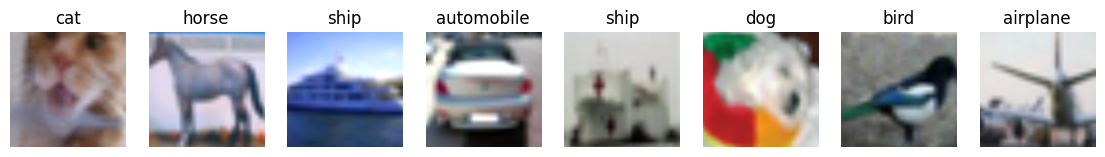

In [4]:
def denorm(img_t):
    # img_t: (3,H,W) normalized
    mean = torch.tensor(IMAGENET_MEAN).view(3,1,1)
    std  = torch.tensor(IMAGENET_STD).view(3,1,1)
    img = img_t.cpu() * std + mean
    return img.clamp(0,1)

def show_batch(loader, n=8):
    x, y = next(iter(loader))
    plt.figure(figsize=(14,4))
    for i in range(n):
        plt.subplot(1,n,i+1)
        plt.imshow(denorm(x[i]).permute(1,2,0))
        plt.title(class_names[y[i]])
        plt.axis("off")
    plt.show()

show_batch(train_loader, n=8)


Models: ResNet baseline, MobileNet baseline, and Fused model
Helper: build feature extractors (remove classifiers)

In [5]:
def build_resnet18_feature_extractor(pretrained=True):
    m = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
    # Replace final FC with identity -> outputs 512-d features
    m.fc = nn.Identity()
    return m, 512

def build_mobilenetv2_feature_extractor(pretrained=True):
    m = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT if pretrained else None)
    # Replace classifier with identity -> outputs 1280-d features
    m.classifier = nn.Identity()
    return m, 1280


**Baseline models**

In [6]:
class SingleBackboneClassifier(nn.Module):
    def __init__(self, backbone, feat_dim, num_classes, dropout=0.2):
        super().__init__()
        self.backbone = backbone
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(feat_dim, num_classes)
        )

    def forward(self, x):
        f = self.backbone(x)
        return self.head(f)


# Fusion model (feature concatenation + MLP)

In [7]:
class FusionConcatClassifier(nn.Module):
    def __init__(self, resnet_backbone, mobilenet_backbone, res_dim=512, mob_dim=1280,
                 num_classes=10, hidden=512, dropout=0.3):
        super().__init__()
        self.resnet = resnet_backbone
        self.mobilenet = mobilenet_backbone

        fusion_dim = res_dim + mob_dim
        self.mlp = nn.Sequential(
            nn.Linear(fusion_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, num_classes)
        )

    def forward(self, x):
        f1 = self.resnet(x)      # [B, 512]
        f2 = self.mobilenet(x)   # [B, 1280]
        f = torch.cat([f1, f2], dim=1)
        return self.mlp(f)


Accuracy + train/eval loops

In [8]:
@torch.no_grad()
def accuracy_from_logits(logits, y):
    preds = logits.argmax(dim=1)
    return (preds == y).float().mean().item()

def train_one_epoch(model, loader, optimizer, criterion, scaler=None):
    model.train()
    running_loss, running_acc = 0.0, 0.0
    n = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)

        # Mixed precision (helps speed on GPU)
        if scaler is not None:
            with torch.autocast(device_type=device if device=="cuda" else "cpu", enabled=(device=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

        bs = x.size(0)
        running_loss += loss.item() * bs
        running_acc  += (logits.argmax(1) == y).float().sum().item()
        n += bs

    return running_loss / n, running_acc / n

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, running_acc = 0.0, 0.0
    n = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        bs = x.size(0)
        running_loss += loss.item() * bs
        running_acc  += (logits.argmax(1) == y).float().sum().item()
        n += bs

    return running_loss / n, running_acc / n


Full training runner

In [9]:
def fit_model(model, train_loader, val_loader, epochs=10, lr=3e-4, wd=1e-4,
              freeze_epochs=2, label_smoothing=0.1, use_amp=True):

    model = model.to(device)

    # Label smoothing often stabilizes and improves accuracy a bit
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

    scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device=="cuda"))

    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    best_val_acc = -1
    best_state = None

    # Freeze feature extractors early to avoid overfitting + speed up
    def set_backbones_trainable(trainable: bool):
        for p in model.parameters():
            p.requires_grad = True
        # if model has specific backbones, freeze them
        if hasattr(model, "resnet"):
            for p in model.resnet.parameters():
                p.requires_grad = trainable
        if hasattr(model, "mobilenet"):
            for p in model.mobilenet.parameters():
                p.requires_grad = trainable
        if hasattr(model, "backbone"):
            for p in model.backbone.parameters():
                p.requires_grad = trainable

    for epoch in range(1, epochs+1):
        # Freeze for first few epochs, then fine-tune all
        if epoch <= freeze_epochs:
            set_backbones_trainable(False)
        else:
            set_backbones_trainable(True)

        t0 = time.time()
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, scaler=scaler)
        va_loss, va_acc = evaluate(model, val_loader, criterion)
        scheduler.step()

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss)
        history["val_acc"].append(va_acc)

        if va_acc > best_val_acc:
            best_val_acc = va_acc
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        dt = time.time() - t0
        print(f"Epoch {epoch:02d}/{epochs} | "
              f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
              f"val loss {va_loss:.4f} acc {va_acc:.4f} | {dt:.1f}s")

    # Load best
    model.load_state_dict(best_state)
    return model, history, best_val_acc


In [10]:
def plot_history(history, title="Training Curves"):
    epochs = range(1, len(history["train_loss"])+1)
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="train_loss")
    plt.plot(epochs, history["val_loss"], label="val_loss")
    plt.title(title + " - Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="train_acc")
    plt.plot(epochs, history["val_acc"], label="val_acc")
    plt.title(title + " - Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.legend()

    plt.show()


4.1 ResNet18 baseline

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s]
/tmp/ipython-input-75269454.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device=="cuda"))


Epoch 01/8 | train loss 1.5389 acc 0.5544 | val loss 1.2120 acc 0.7140 | 251.9s
Epoch 02/8 | train loss 1.2560 acc 0.6844 | val loss 1.1647 acc 0.7334 | 244.6s
Epoch 03/8 | train loss 1.2159 acc 0.6988 | val loss 1.1429 acc 0.7280 | 238.6s
Epoch 04/8 | train loss 0.8542 acc 0.8714 | val loss 0.7178 acc 0.9270 | 241.9s
Epoch 05/8 | train loss 0.6979 acc 0.9370 | val loss 0.6785 acc 0.9384 | 242.6s
Epoch 06/8 | train loss 0.6368 acc 0.9629 | val loss 0.6434 acc 0.9484 | 242.0s
Epoch 07/8 | train loss 0.5989 acc 0.9779 | val loss 0.6212 acc 0.9604 | 241.7s
Epoch 08/8 | train loss 0.5795 acc 0.9863 | val loss 0.6091 acc 0.9632 | 240.9s


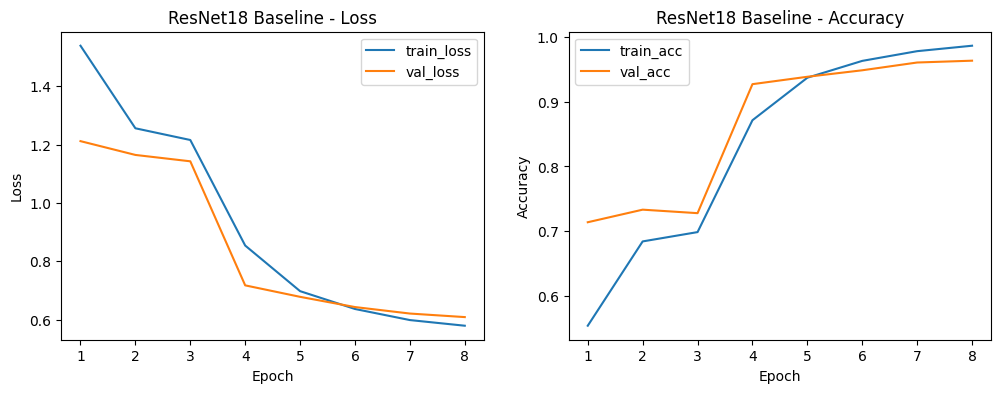

Best val acc: 0.9632


In [11]:
resnet_feat, res_dim = build_resnet18_feature_extractor(pretrained=True)
resnet_model = SingleBackboneClassifier(resnet_feat, res_dim, num_classes=num_classes, dropout=0.2)

resnet_model, res_hist, res_best = fit_model(
    resnet_model, train_loader, val_loader,
    epochs=8, lr=3e-4, wd=1e-4, freeze_epochs=3,
    label_smoothing=0.1
)
plot_history(res_hist, title="ResNet18 Baseline")
print("Best val acc:", res_best)


4.2 MobileNetV2 baseline

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 107MB/s]
/tmp/ipython-input-75269454.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device=="cuda"))


Epoch 01/8 | train loss 1.5832 acc 0.5851 | val loss 1.3430 acc 0.6472 | 242.6s
Epoch 02/8 | train loss 1.3006 acc 0.6662 | val loss 1.2755 acc 0.6600 | 235.1s
Epoch 03/8 | train loss 1.2548 acc 0.6836 | val loss 1.2493 acc 0.6758 | 235.9s
Epoch 04/8 | train loss 0.8692 acc 0.8543 | val loss 0.7348 acc 0.9090 | 266.5s
Epoch 05/8 | train loss 0.7122 acc 0.9213 | val loss 0.6841 acc 0.9280 | 255.4s
Epoch 06/8 | train loss 0.6575 acc 0.9446 | val loss 0.6566 acc 0.9406 | 252.0s
Epoch 07/8 | train loss 0.6309 acc 0.9565 | val loss 0.6478 acc 0.9474 | 254.3s
Epoch 08/8 | train loss 0.6173 acc 0.9623 | val loss 0.6427 acc 0.9478 | 254.7s


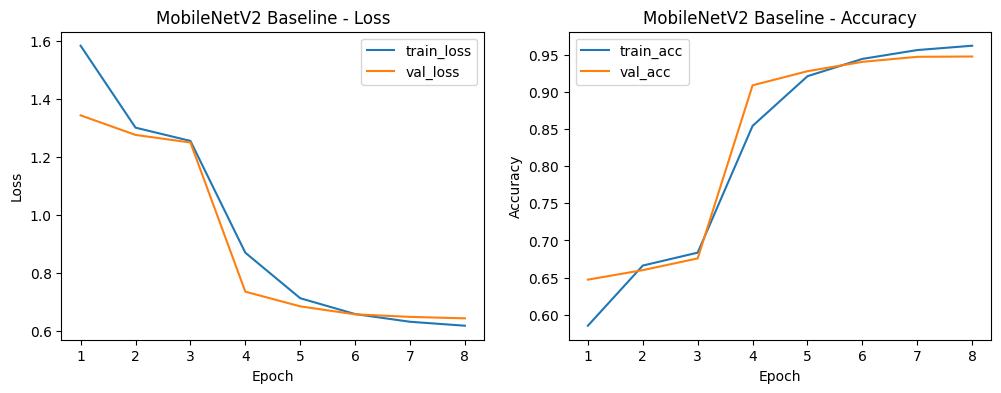

Best val acc: 0.9478


In [12]:
mob_feat, mob_dim = build_mobilenetv2_feature_extractor(pretrained=True)
mob_model = SingleBackboneClassifier(mob_feat, mob_dim, num_classes=num_classes, dropout=0.2)

mob_model, mob_hist, mob_best = fit_model(
    mob_model, train_loader, val_loader,
    epochs=8, lr=3e-4, wd=1e-4, freeze_epochs=3,
    label_smoothing=0.1
)
plot_history(mob_hist, title="MobileNetV2 Baseline")
print("Best val acc:", mob_best)


Train Fusion Model

/tmp/ipython-input-75269454.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device=="cuda"))


Epoch 01/8 | train loss 1.1645 acc 0.7257 | val loss 1.0969 acc 0.7426 | 243.9s
Epoch 02/8 | train loss 1.0394 acc 0.7805 | val loss 1.0237 acc 0.7854 | 241.3s
Epoch 03/8 | train loss 1.0089 acc 0.7950 | val loss 0.9868 acc 0.8052 | 241.4s
Epoch 04/8 | train loss 0.8097 acc 0.8860 | val loss 0.6912 acc 0.9296 | 270.4s
Epoch 05/8 | train loss 0.6674 acc 0.9429 | val loss 0.6501 acc 0.9448 | 267.4s
Epoch 06/8 | train loss 0.6094 acc 0.9670 | val loss 0.6194 acc 0.9560 | 270.4s
Epoch 07/8 | train loss 0.5751 acc 0.9819 | val loss 0.6050 acc 0.9632 | 272.6s
Epoch 08/8 | train loss 0.5575 acc 0.9890 | val loss 0.5958 acc 0.9652 | 272.7s


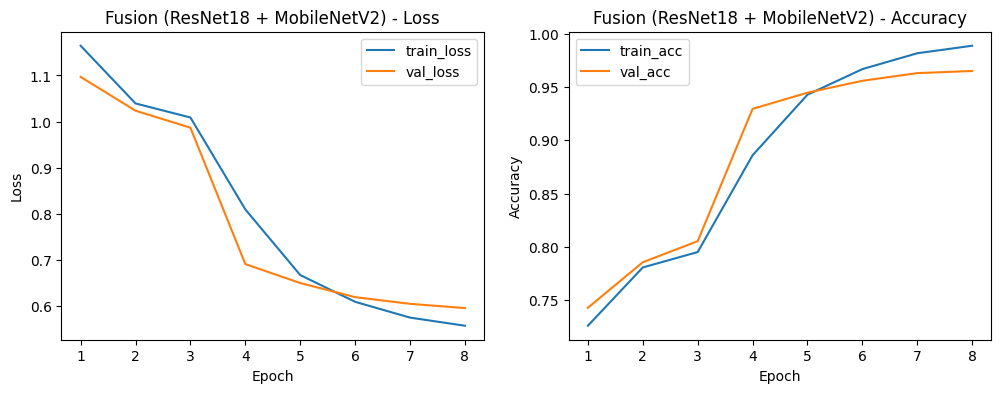

Best val acc: 0.9652


In [13]:
resnet_feat, res_dim = build_resnet18_feature_extractor(pretrained=True)
mob_feat, mob_dim    = build_mobilenetv2_feature_extractor(pretrained=True)

fusion_model = FusionConcatClassifier(
    resnet_backbone=resnet_feat,
    mobilenet_backbone=mob_feat,
    res_dim=res_dim,
    mob_dim=mob_dim,
    num_classes=num_classes,
    hidden=512,
    dropout=0.3
)

fusion_model, fus_hist, fus_best = fit_model(
    fusion_model, train_loader, val_loader,
    epochs=8, lr=3e-4, wd=1e-4, freeze_epochs=3,
    label_smoothing=0.1
)
plot_history(fus_hist, title="Fusion (ResNet18 + MobileNetV2)")
print("Best val acc:", fus_best)


Test evaluation + confusion matrix + report text outputs


ResNet18 Test Accuracy: 0.9612


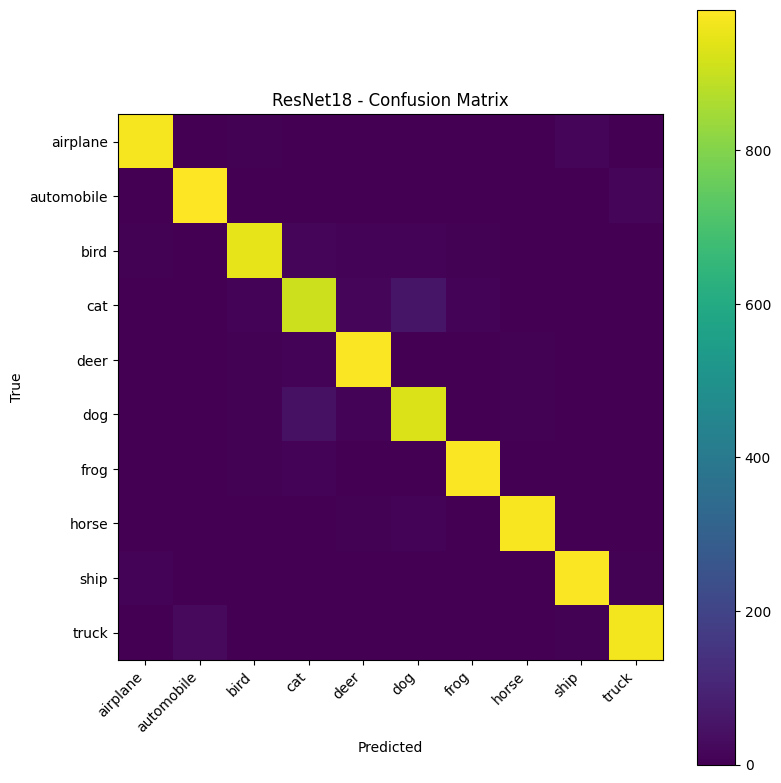

              precision    recall  f1-score   support

    airplane       0.97      0.97      0.97      1000
  automobile       0.97      0.98      0.98      1000
        bird       0.97      0.95      0.96      1000
         cat       0.91      0.91      0.91      1000
        deer       0.96      0.98      0.97      1000
         dog       0.92      0.93      0.93      1000
        frog       0.98      0.98      0.98      1000
       horse       0.98      0.97      0.98      1000
        ship       0.97      0.98      0.98      1000
       truck       0.98      0.97      0.97      1000

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000


MobileNetV2 Test Accuracy: 0.9451


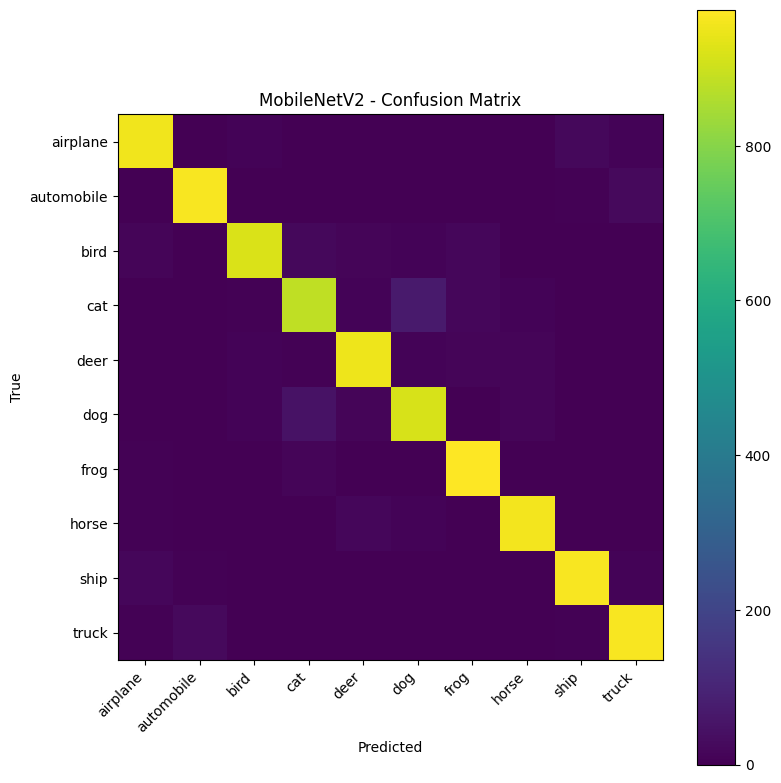

              precision    recall  f1-score   support

    airplane       0.95      0.95      0.95      1000
  automobile       0.97      0.97      0.97      1000
        bird       0.96      0.92      0.94      1000
         cat       0.90      0.88      0.89      1000
        deer       0.94      0.95      0.95      1000
         dog       0.90      0.92      0.91      1000
        frog       0.95      0.98      0.96      1000
       horse       0.96      0.96      0.96      1000
        ship       0.96      0.96      0.96      1000
       truck       0.96      0.96      0.96      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000


Fusion Test Accuracy: 0.9624


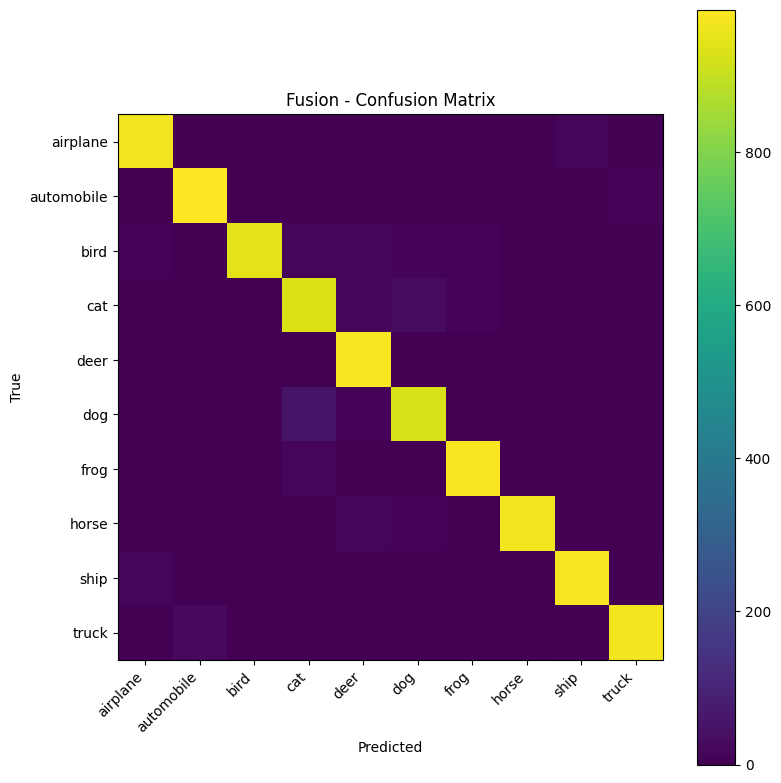

              precision    recall  f1-score   support

    airplane       0.97      0.97      0.97      1000
  automobile       0.97      0.99      0.98      1000
        bird       0.97      0.94      0.96      1000
         cat       0.90      0.93      0.92      1000
        deer       0.95      0.97      0.96      1000
         dog       0.95      0.93      0.94      1000
        frog       0.98      0.98      0.98      1000
       horse       0.98      0.97      0.98      1000
        ship       0.97      0.97      0.97      1000
       truck       0.98      0.97      0.97      1000

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [14]:
@torch.no_grad()
def get_all_preds(model, loader):
    model.eval()
    all_preds, all_y = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_y.append(y.numpy())
    return np.concatenate(all_preds), np.concatenate(all_y)

def plot_confusion(cm, class_names, title="Confusion Matrix"):
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45, ha="right")
    plt.yticks(ticks, class_names)
    plt.tight_layout()
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Evaluate on TEST for baselines + fusion (great for your Discussion section)
models_dict = {
    "ResNet18": resnet_model,
    "MobileNetV2": mob_model,
    "Fusion": fusion_model
}

for name, m in models_dict.items():
    preds, ytrue = get_all_preds(m, test_loader)
    acc = (preds == ytrue).mean()
    print(f"\n{name} Test Accuracy: {acc:.4f}")
    cm = confusion_matrix(ytrue, preds)
    plot_confusion(cm, class_names, title=f"{name} - Confusion Matrix")
    print(classification_report(ytrue, preds, target_names=class_names))


Show correct + incorrect predictions

Fusion: sample predictions


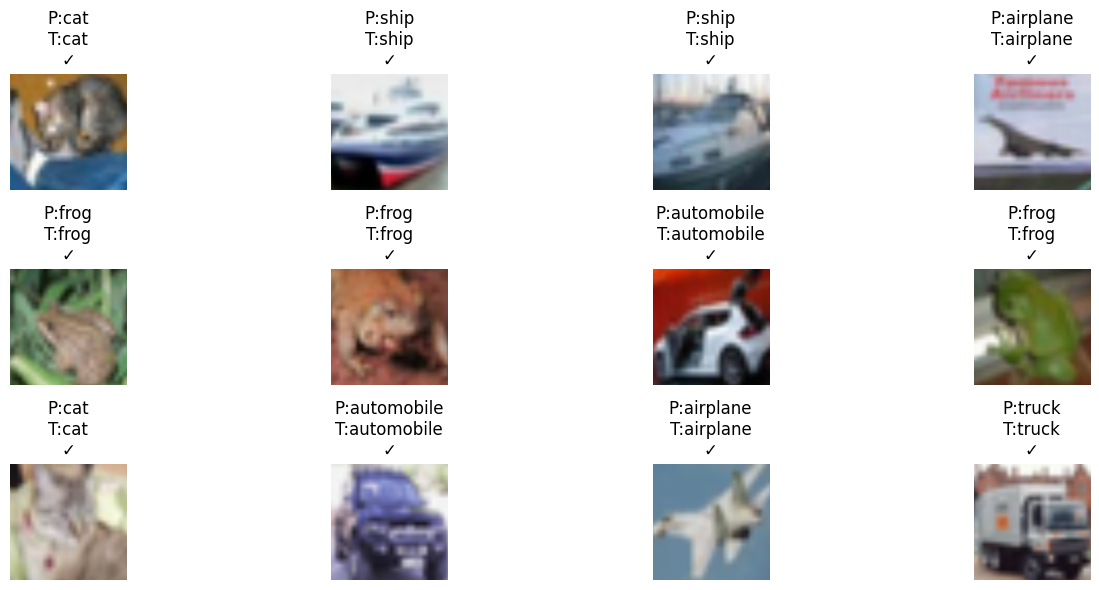

Fusion: incorrect predictions


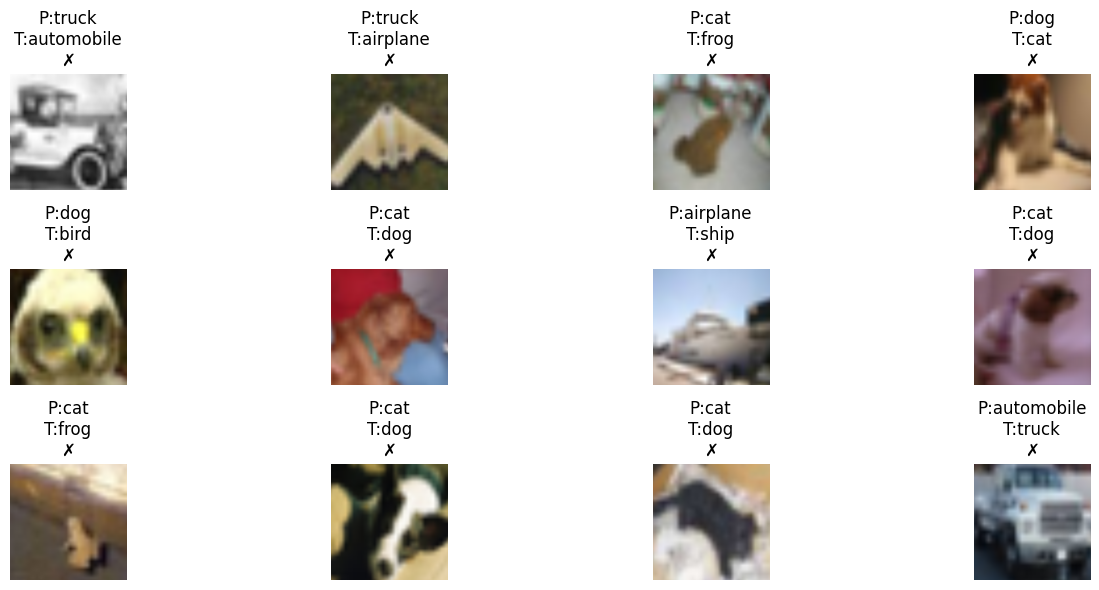

In [15]:
@torch.no_grad()
def show_predictions(model, loader, n=12):
    model.eval()
    x, y = next(iter(loader))
    x = x.to(device)
    logits = model(x)
    preds = logits.argmax(1).cpu()

    x_cpu = x.cpu()
    y_cpu = y
    plt.figure(figsize=(14,6))
    for i in range(n):
        plt.subplot(3, 4, i+1)
        plt.imshow(denorm(x_cpu[i]).permute(1,2,0))
        ok = (preds[i].item() == y_cpu[i].item())
        plt.title(f"P:{class_names[preds[i]]}\nT:{class_names[y_cpu[i]]}\n{'✓' if ok else '✗'}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

def show_incorrect(model, loader, n=12):
    model.eval()
    wrong_imgs = []
    wrong_info = []

    for x, y in loader:
        x_dev = x.to(device)
        logits = model(x_dev)
        preds = logits.argmax(1).cpu()
        for i in range(x.size(0)):
            if preds[i].item() != y[i].item():
                wrong_imgs.append(x[i])
                wrong_info.append((preds[i].item(), y[i].item()))
            if len(wrong_imgs) >= n:
                break
        if len(wrong_imgs) >= n:
            break

    plt.figure(figsize=(14,6))
    for i in range(n):
        plt.subplot(3,4,i+1)
        plt.imshow(denorm(wrong_imgs[i]).permute(1,2,0))
        p, t = wrong_info[i]
        plt.title(f"P:{class_names[p]}\nT:{class_names[t]}\n✗")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

print("Fusion: sample predictions")
show_predictions(fusion_model, test_loader, n=12)

print("Fusion: incorrect predictions")
show_incorrect(fusion_model, test_loader, n=12)


Architecture diagram

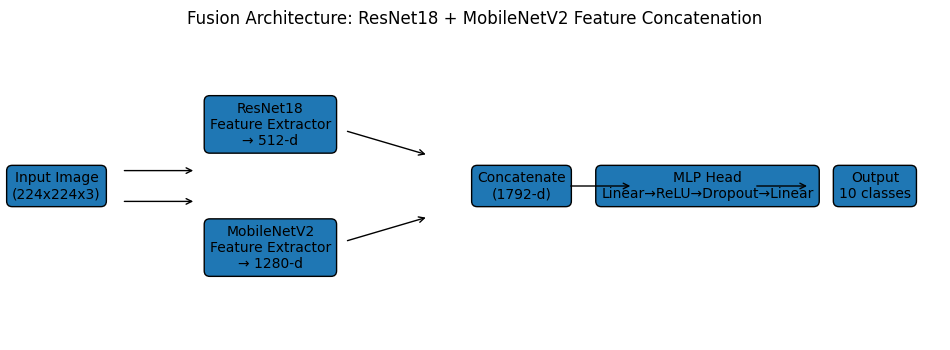

In [16]:
def draw_architecture_diagram():
    plt.figure(figsize=(12,4))
    plt.axis("off")

    boxes = [
        (0.05, 0.5, "Input Image\n(224x224x3)"),
        (0.28, 0.7, "ResNet18\nFeature Extractor\n→ 512-d"),
        (0.28, 0.3, "MobileNetV2\nFeature Extractor\n→ 1280-d"),
        (0.55, 0.5, "Concatenate\n(1792-d)"),
        (0.75, 0.5, "MLP Head\nLinear→ReLU→Dropout→Linear"),
        (0.93, 0.5, "Output\n10 classes")
    ]

    for (x,y,text) in boxes:
        plt.text(x, y, text, ha="center", va="center",
                 bbox=dict(boxstyle="round,pad=0.4", linewidth=1))

    # arrows (rough)
    plt.annotate("", xy=(0.20,0.55), xytext=(0.12,0.55), arrowprops=dict(arrowstyle="->"))
    plt.annotate("", xy=(0.20,0.45), xytext=(0.12,0.45), arrowprops=dict(arrowstyle="->"))
    plt.annotate("", xy=(0.45,0.60), xytext=(0.36,0.68), arrowprops=dict(arrowstyle="->"))
    plt.annotate("", xy=(0.45,0.40), xytext=(0.36,0.32), arrowprops=dict(arrowstyle="->"))
    plt.annotate("", xy=(0.67,0.50), xytext=(0.60,0.50), arrowprops=dict(arrowstyle="->"))
    plt.annotate("", xy=(0.86,0.50), xytext=(0.80,0.50), arrowprops=dict(arrowstyle="->"))

    plt.title("Fusion Architecture: ResNet18 + MobileNetV2 Feature Concatenation")
    plt.show()

draw_architecture_diagram()
